In [1]:
"""
    Constructing TQQQ TMF Portfolio
"""
## Asset Allocation Model
# Two Leveraged ETFs with dynamic allocation
# Case 1: No Rebalancing

import zipline
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, get_datetime, set_benchmark
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [2]:
"""
    Model Settings
"""
initial_portfolio = 10000
vola_window = 20

def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().mean() #iloc[-1]
    return std
#    return ts.pct_change().rolling(vola_window).std().iloc[-1]

def output_progress(context):
    """
        Output some performance numbers during backtest
    """
    # get today's date
    today = zipline.api.get_datetime().date()
    
    # calculate percent diff since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance
    print("{} - Last Month Result: {:.2%}.".format(today, perf_pct))

    # Remember today's portfolio value for next month calc
    context.last_month = context.portfolio.portfolio_value

In [3]:
def initialize(context):
    # Used only for progress report
    context.last_month = initial_portfolio
    # Used for history window
    context.vola_window = vola_window

    # ETF
    etfs = ['TMF', 'TQQQ']
    context.etfs = [symbol(s) for s in etfs]
    
    context.has_ordered = False
    
    set_benchmark(False)

In [4]:
def handle_data(context, data):
    # trading logic
    if not context.has_ordered:
        # Get historical 126 day data for volatility calculation
        hist = data.history(context.etfs, "close", 126, "1d")
        hist = hist.dropna()

        # Calculate inverse volatility for etfs and make target positions weights
        vola_table = hist[context.etfs].apply(volatility)
        inv_vola_table = 1 / vola_table
        sum_inv_vola = np.sum(inv_vola_table)
        vola_target_weights = inv_vola_table / sum_inv_vola

        for etf in context.etfs:
            weight = vola_target_weights[etf]
            order_target_percent(etf, weight)

        # setting up a flag for holding a position
        context.has_ordered = True

In [5]:
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf

In [6]:
def analyze(context, perf):
    returns, positions, transactions, leverage = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions, round_trips = True)

Entire data start date: 2010-12-31
Entire data end date: 2020-08-19


Backtest Months: 115


Performance statistics,Backtest
annual_return,0.40
annual_volatility,0.41
sharpe_ratio,1.03
calmar_ratio,0.64
stability_of_timeseries,0.99
max_drawdown,-0.63
omega_ratio,1.22
sortino_ratio,1.43
skew,-0.79
kurtosis,12.04


/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/timeseries.py:416: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  beta, alpha = sp.stats.linregress(factor_returns.loc[ret_index].values,
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,62.86,2020-02-19,2020-03-20,2020-07-09,102
1,53.59,2018-08-29,2018-12-24,2019-10-28,304
2,28.47,2015-12-01,2016-02-09,2016-07-08,159
3,26.94,2018-01-26,2018-02-08,2018-03-12,32
4,26.57,2015-07-21,2015-08-25,2015-12-01,96




[-0.05 -0.1 ]


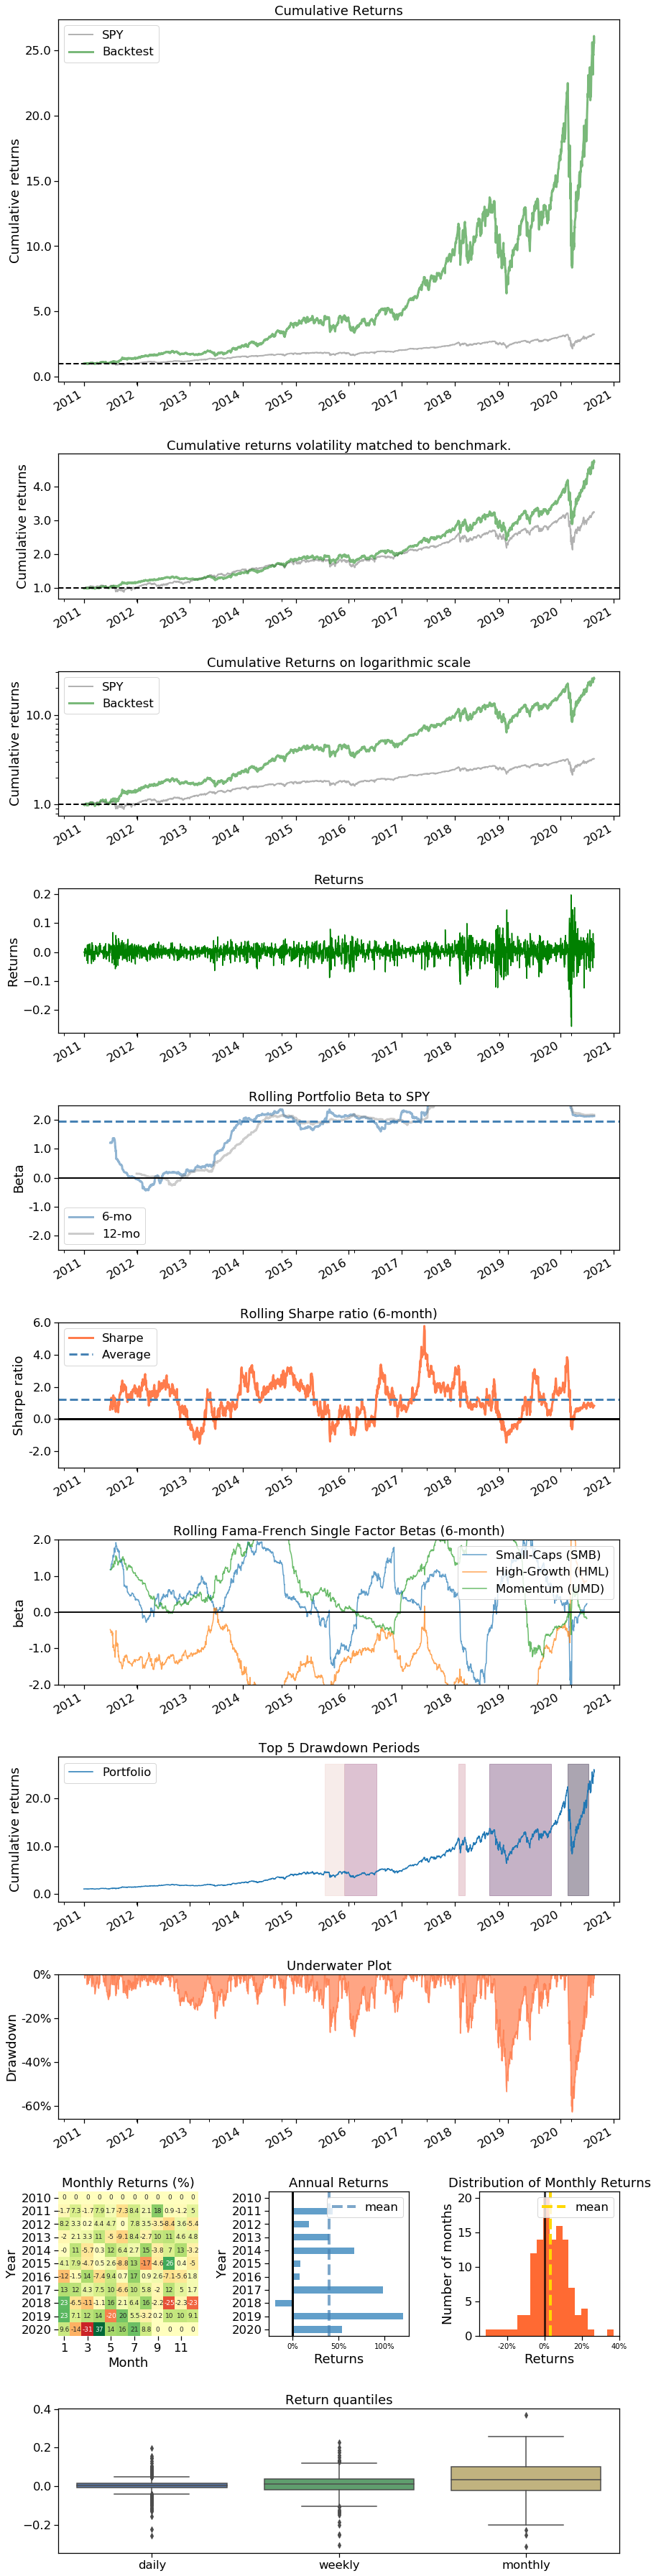

Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.35%,-5.82%,5.80%
Fukushima,0.15%,-2.67%,2.24%
EZB IR Event,-0.28%,-2.97%,1.83%
Apr14,0.11%,-5.82%,3.21%
Oct14,0.32%,-4.48%,4.59%
Fall2015,-0.59%,-8.86%,7.96%
Recovery,0.12%,-5.82%,6.80%
New Normal,0.18%,-25.74%,19.83%


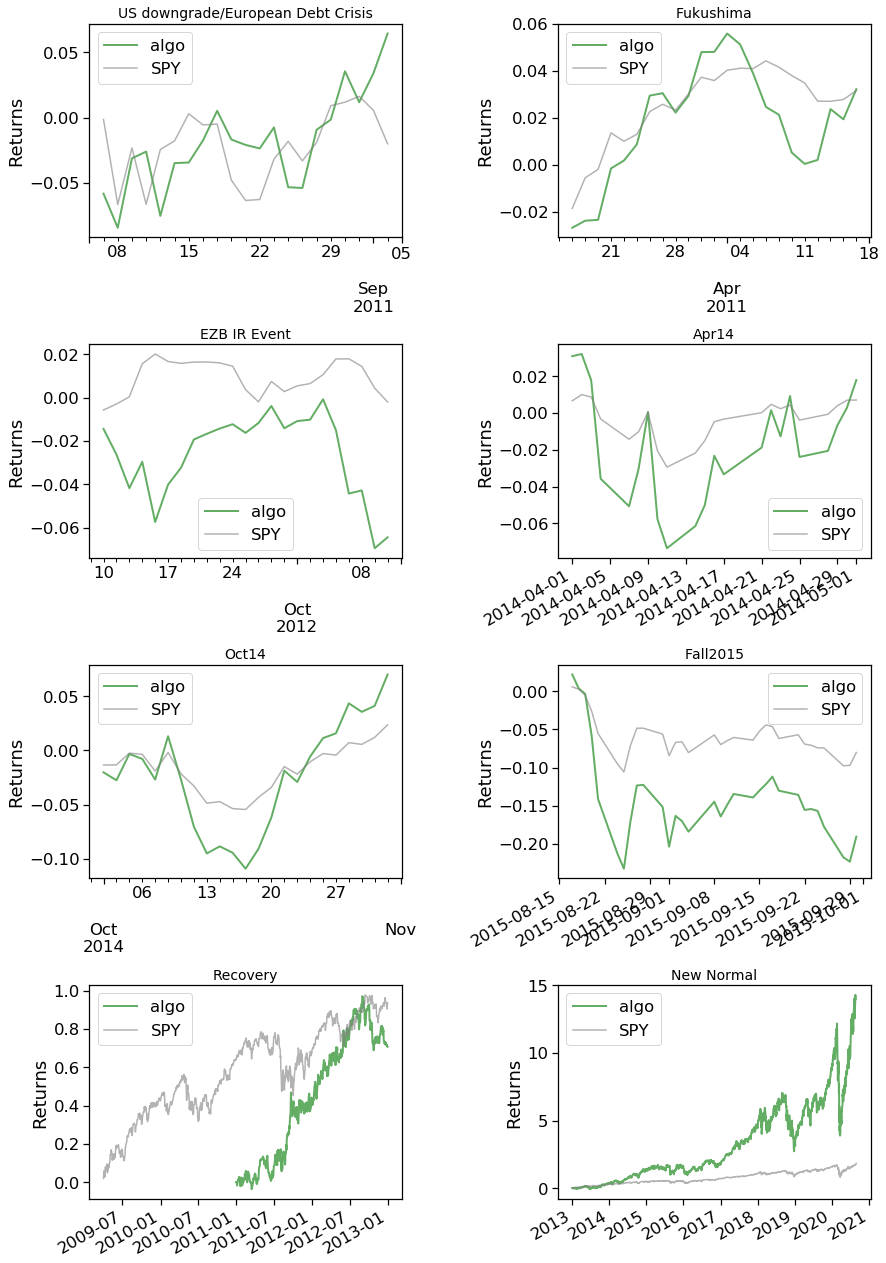

Top 10 long positions of all time,max
Equity(204 [TQQQ]),93.41%
Equity(200 [TMF]),73.14%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Equity(204 [TQQQ]),93.41%
Equity(200 [TMF]),73.14%


All positions ever held,max
Equity(204 [TQQQ]),93.41%
Equity(200 [TMF]),73.14%


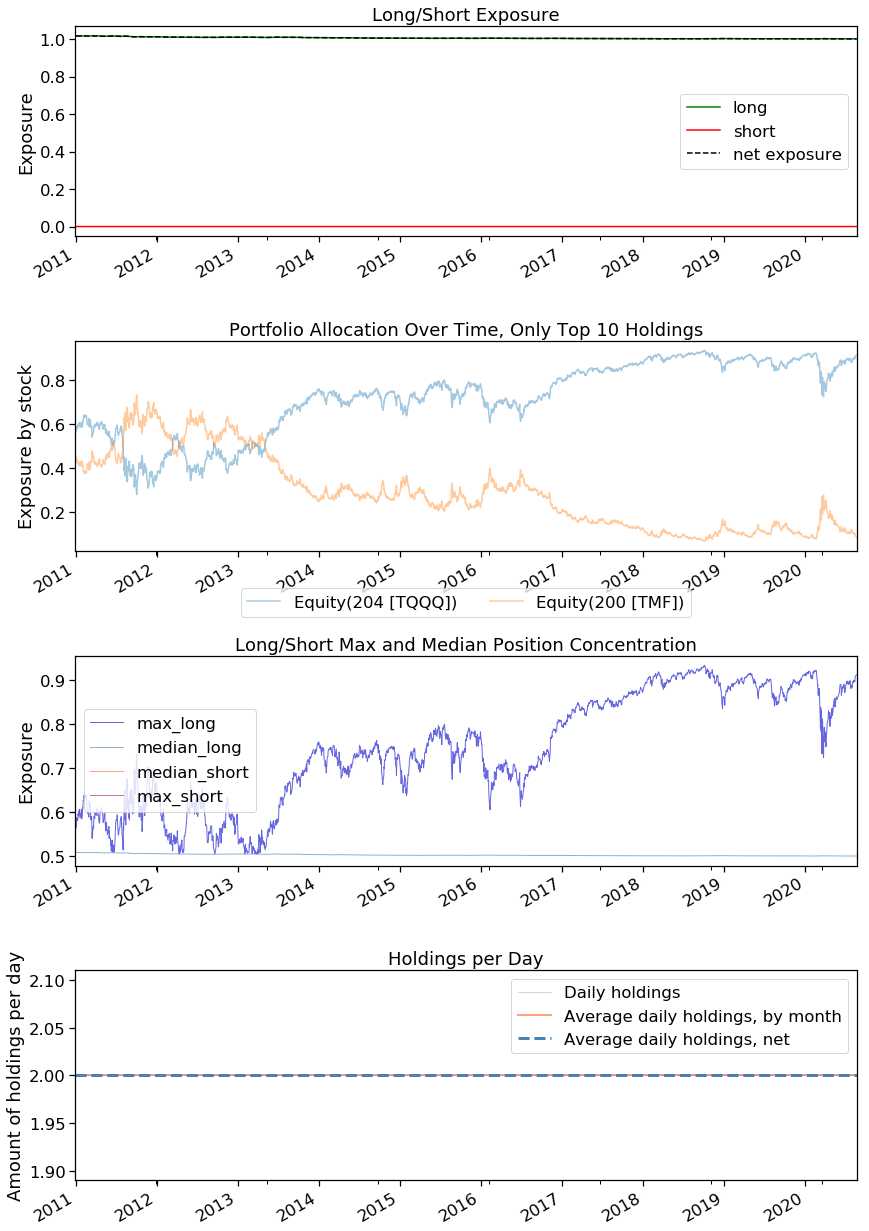

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/plotting.py:1210: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  **kwargs)


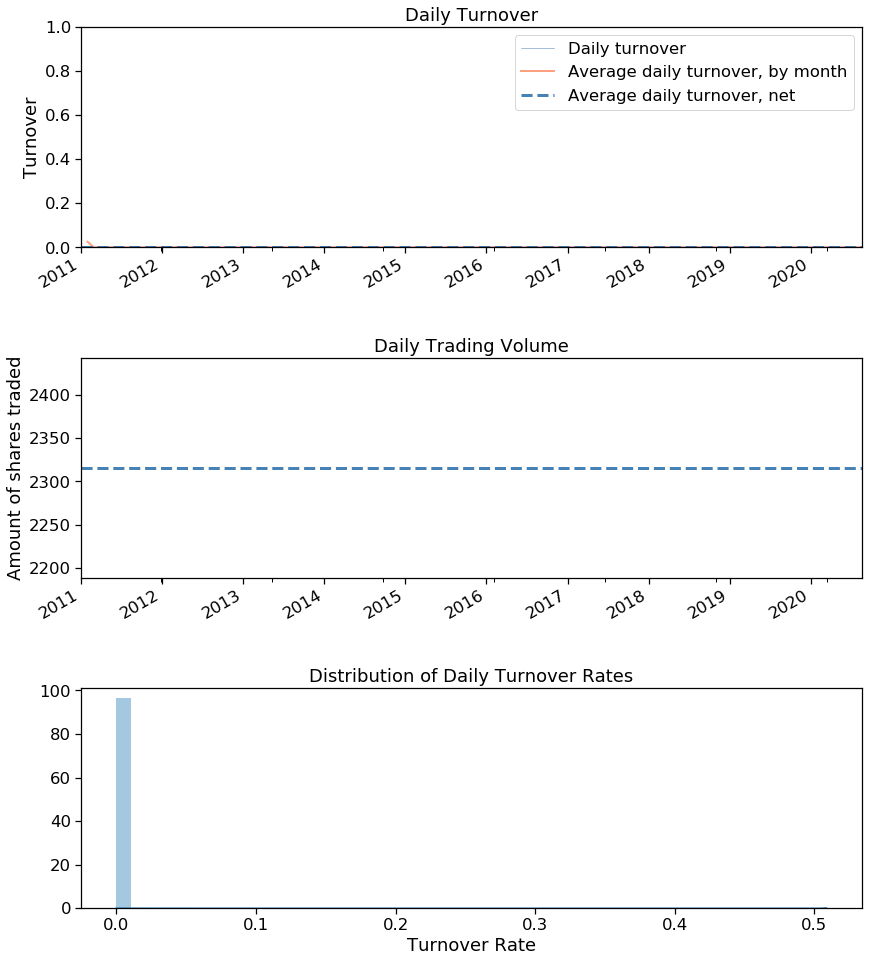

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/tears.py:590: UserWarning: Fewer than 5 round-trip trades made.
               Skipping round trip tearsheet.
  Skipping round trip tearsheet.""", UserWarning)


In [7]:
# Set start and end
#start = datetime(2010, 2, 12, 8, 15, 12, 0, pytz.UTC)
#end = datetime(2020, 7, 31, 8, 15, 12, 0, pytz.UTC)
start = pd.to_datetime('2010-12-31', utc=True)
end = pd.to_datetime('2020-08-19', utc=True)

# Fire off backtest
result = zipline.run_algorithm(
    start = start, 
    end = end, 
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    capital_base = 10000, 
    data_frequency = 'daily', 
    bundle = 'etf_db_data'
)

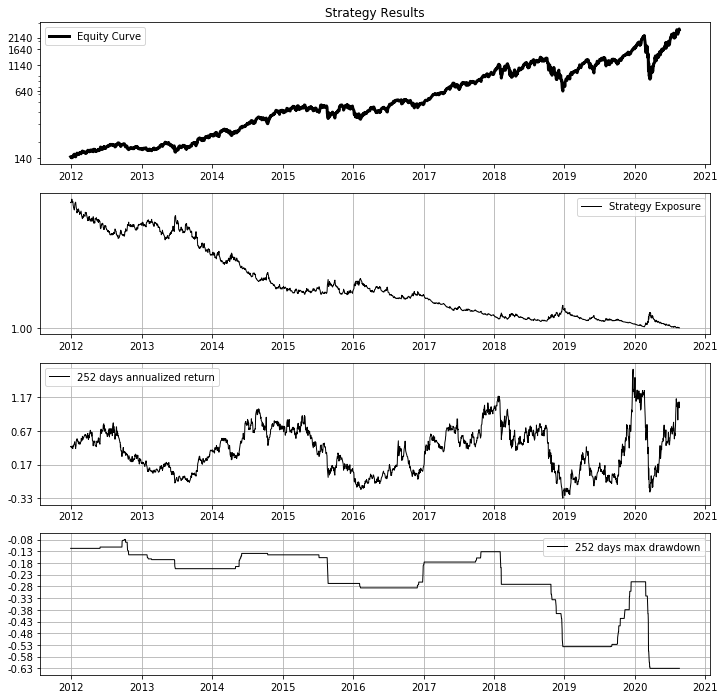

In [8]:
# Analytics - Annualized Return and Maximum drawdown

# settings
window = 252
year_length = 252

# copy needed columns
df = result.copy().filter(items=['portfolio_value', 'gross_leverage'])

# Annualized Return = (End Value / Start Value) ** (Year Days / Actual Days) - 1
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length / len(ts))) - 1

# Maximum drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# rolling window
rolling_window = result.portfolio_value.rolling(window)

# rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# drop initial n/a
df.dropna(inplace = True)

# Figure
fig = plt.figure(figsize = (12, 12))

# Reduce base for easy readability
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], linestyle = '-', color = 'black', label = 'Equity Curve', linewidth = 3.0)

# log scale
ax.set_yscale('log')

# prettier axis
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        linestyle = '-', color = 'black', label = 'Strategy Exposure'.format(window), linewidth = 1.0)

# prettier axis
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        linestyle = '-', color = 'black', label = '{} days annualized return'.format(window), linewidth = 1.0)

# prettier axis
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        linestyle = '-', color = 'black', label = '{} days max drawdown'.format(window), linewidth = 1.0)

# prettier axis
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# legend and grid
ax.legend()
ax.grid(True)